In [1]:
import os
import numpy as np
import tensorflow_probability as tfp
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
mnist2 = input_data.read_data_sets('MNIST_data/')

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [3]:
mnist2.test.images[0]
len(mnist2.test.images)
len(mnist2.test.images[0])

784

In [4]:
mnist2.test.labels
len(mnist2.test.labels)

10000

In [5]:
tfd = tfp.distributions
input_size = 28 * 28

decoder_std = 0.5
epochs = 150
batch_size = 128

In [6]:
class VAE(object):
    def __init__(self, learning_rate=0.001, decoder_std = 0.5, latent_dim=2):
        #set hyperparameters
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, input_size])
        self.learning_rate = learning_rate
        self.decoder_std = decoder_std
        self.latent_dim = latent_dim
        
        self.build()
        
        #Initialize parameters
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def encoder(self, x):
        x1 = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x2 = tf.layers.dense(x1, 256, activation=tf.nn.relu)
        self.mu = tf.layers.dense(x2, self.latent_dim)
        self.scale = tf.layers.dense(x2, self.latent_dim)
        std = tf.sqrt(1e-5 + tf.exp(self.scale))
        return self.mu, std
    
    def prior(self):
        loc = tf.zeros(self.latent_dim)
        scale = tf.ones(self.latent_dim)
        return tfd.MultivariateNormalDiag(loc, scale)
    
    def decoder(self, z, input_size=28*28): #input_size=784
        z1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        z2 = tf.layers.dense(z1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(z2, input_size)
        self.decoder_std = tf.sqrt(1e-5 + tf.exp(tf.layers.dense(z2, input_size, tf.nn.softplus)))
        return mu

    
    def build(self):
        
        self.encoder = tf.make_template('encoder', self.encoder)
        self.decoder = tf.make_template('decoder', self.decoder)
        
        #encode an image into the distribution of latent space
        self.encoder_mu, self.encoder_std = self.encoder(self.x)

        #sample by reparametrisation
        eps = tf.random_normal(shape=[tf.shape(self.x)[0], self.latent_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
        self.z = self.encoder_mu + self.encoder_std*eps

        #decode latent vector z
        self.decoder_mu = self.decoder(self.z)

        
        self.posterior = tfd.MultivariateNormalDiag(self.encoder_mu, self.encoder_std)
        prior = self.prior()
        
        #reconstruction loss
        self.likelihood = tfd.Independent(tfd.MultivariateNormalDiag(self.decoder_mu, self.decoder_std)).log_prob(self.x)        
        
        
        #KL divergence loss
        self.divergence = tfd.kl_divergence(self.posterior, prior)
        self.elbo = tf.reduce_mean(self.likelihood - self.divergence, axis=0)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.elbo)
        
        decoder_samp_mu = self.decoder(prior.sample(15))        
        self.samples = tfd.Independent(tfd.MultivariateNormalDiag(decoder_samp_mu, self.decoder_std)).mean()
        return

    def run(self, x):
        self.sess.run(self.optimize, feed_dict={self.x: x})
        return
    
    
    def plot_latent(self, z=[], labels=[]):
        plt.figure(figsize=(5, 4))
        plt.scatter(z[:, 0], z[:, 1], c=labels, s=20)
        plt.xlim(z.min() - .1, z.max() + .1)
        plt.ylim(z.min() - .1, z.max() + .1)
        plt.grid()
        
    def plot_reconstruction(self, x, mnist, h=28, w=28):
        x_reconstructed = x
        n = 15
        I_reconstructed = np.empty((h*1, 2*w*n))
        for i in range(n):
            x = np.concatenate(
                (x_reconstructed[i, :].reshape(h, w), 
                mnist[i, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[0:h, i*2*w:(i+1)*2*w] = x
        plt.figure(figsize=(10, 20))
        plt.imshow(I_reconstructed, cmap='gray')
    
    def plot_samples(self, ax=[], samples=[]):
        for index, sample in enumerate(samples):
            ax[index].imshow(sample, cmap='gray')
            ax[index].axis('off')


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 0 elbo 1015.3884
Epoch 1 elbo 744.35266
Epoch 2 elbo 743.3699
Epoch 3 elbo 742.9809
Epoch 4 elbo 742.6215
Epoch 5 elbo 742.5604
Epoch 6 elbo 742.3071
Epoch 7 elbo 742.2245
Epoch 8 elbo 742.1161
Epoch 9 elbo 742.0751
Epoch 10 elbo 741.9163
Epoch 11 elbo 741.8021
Epoch 12 elbo 741.6938
Epoch 13 elbo 741.5579
Epoch 14 elbo 741.5215
Epoch 15 elbo 741.4599
Epoch 16 elbo 741.2841
Epoch 17 elbo 741.2644
Epoch 18 elbo 741.1925
Epoch 19 elbo 741.0784
Epoch 20 elbo 741.0615
Epoch 21 elbo 741.0464
Epoch 22 elbo 740.9497
Epoch 23 elbo 740.8767
Epoch 24 elbo 740.8655
Epoch 25 elbo 740.768
Epoch 26 elbo 740.7318
Epoch 27 elbo 740.7419
Epoch 28 elbo 740.7541
Epoch 29 elbo 740.6262
Epoch 30 elbo 740.5878
Epoch 31 elbo 740.5826
Epoch 32 elbo 740.5508
Epoch 33 elbo 740.4781
Epoch 34 e

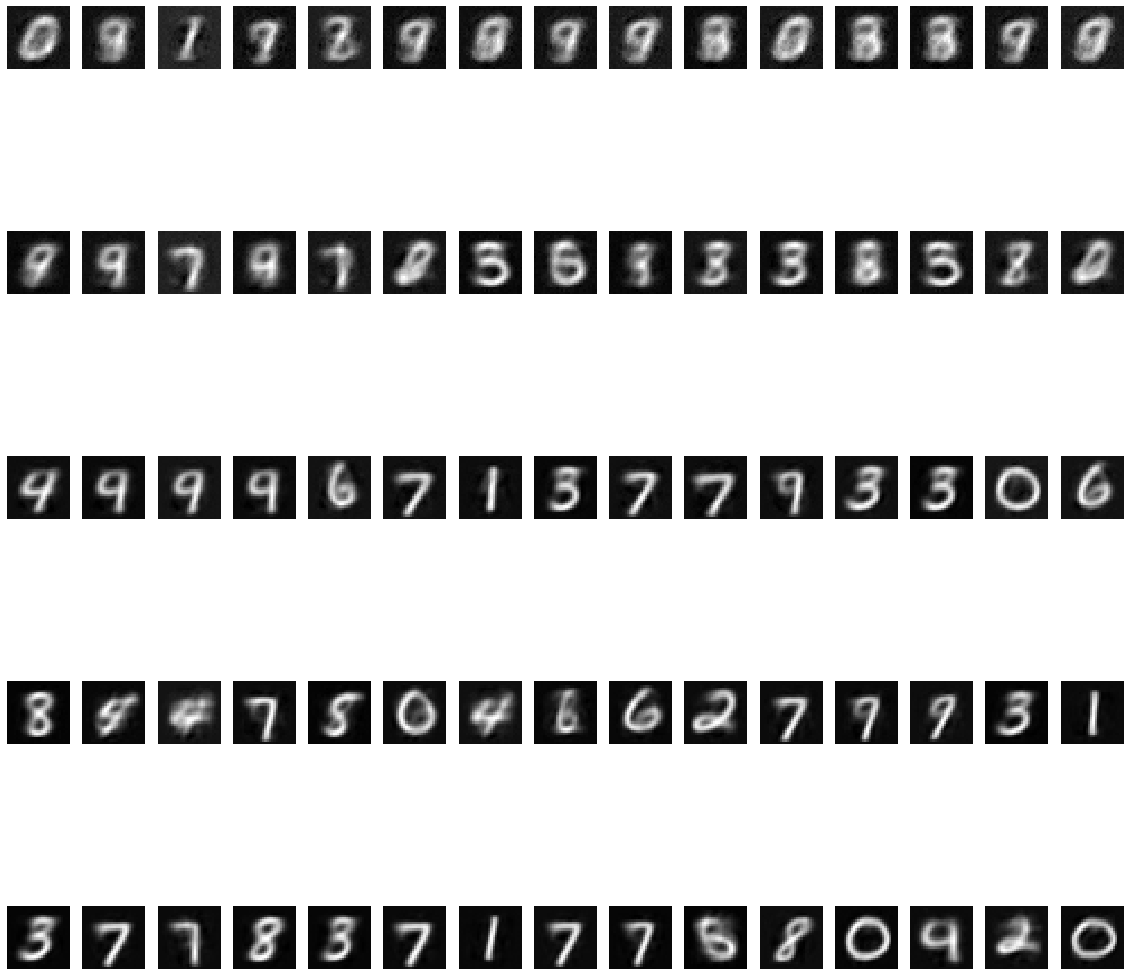

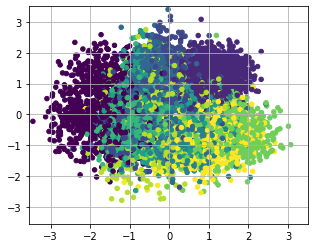

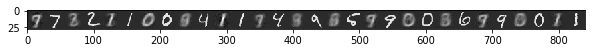

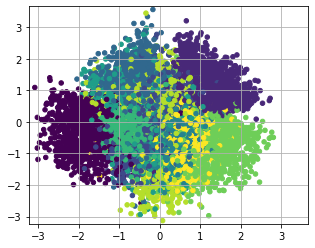

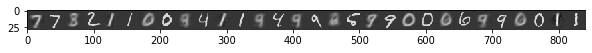

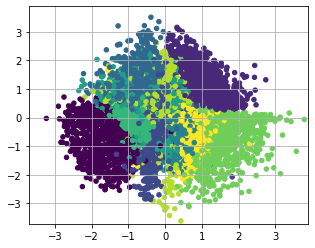

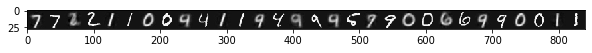

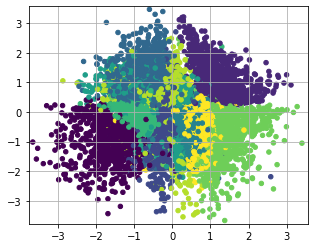

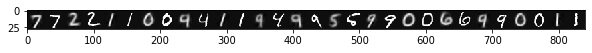

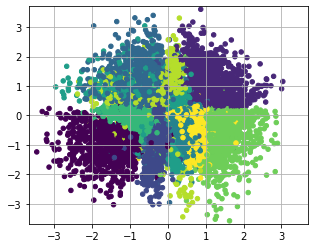

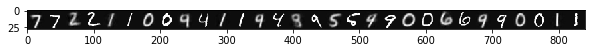

In [7]:
model = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim=2)
fig, ax = plt.subplots(nrows=5, ncols=15, figsize=(20, 20))
i = 0
stop_epoch = 0
elbo = []

for epoch in range(epochs):
    feed = {model.x: mnist2.test.images}
    test_elbo, test_z, test_decoder_mu, test_samples =  model.sess.run(
        [model.elbo, model.z, model.decoder_mu, model.samples], feed)
    elbo.append(-test_elbo)
    print('Epoch', epoch, 'elbo', -test_elbo)
    
    
    #set stop training criteria
    if epoch == 0:
        min_elbo = -test_elbo
    elif -test_elbo < min_elbo:
        min_elbo = -test_elbo
        stop_epoch = 0
    elif -test_elbo > min_elbo:
        stop_epoch+=1
    
    if stop_epoch > 10:
        print('stop at epoch', epoch)
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        break
    
    
    #plot figure   
    if epoch in [1, 5, 25, 50]:    
        model.plot_latent(test_z, mnist2.test.labels)
        model.plot_reconstruction(test_decoder_mu,mnist2.test.images)
        ax[i, 0].set_ylabel('Epoch {}'.format(epoch))
        test_samples = test_samples.reshape([-1, 28, 28])
        model.plot_samples(ax[i, :], test_samples)
        i+=1
        
    #training step 
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model.run(batch)
        
print('train stop!')

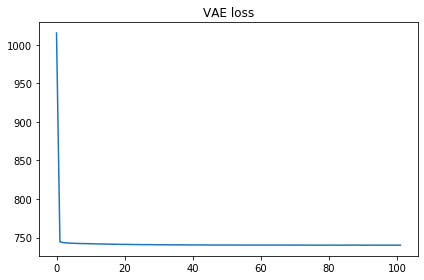

In [8]:
#2-dim latent space loss curve
plt.plot(elbo)
plt.title('VAE loss')
plt.tight_layout()

Epoch 0 elbo 1023.833
Epoch 1 elbo 745.89343
Epoch 2 elbo 743.3422
Epoch 3 elbo 742.1862
Epoch 4 elbo 741.4902
Epoch 5 elbo 741.1572
Epoch 6 elbo 740.88727
Epoch 7 elbo 740.7284
Epoch 8 elbo 740.6465
Epoch 9 elbo 740.5026
Epoch 10 elbo 740.3702
Epoch 11 elbo 740.3132
Epoch 12 elbo 740.1666
Epoch 13 elbo 740.1984
Epoch 14 elbo 739.989
Epoch 15 elbo 739.9709
Epoch 16 elbo 739.9079
Epoch 17 elbo 739.8408
Epoch 18 elbo 739.8369
Epoch 19 elbo 739.73206
Epoch 20 elbo 739.69507
Epoch 21 elbo 739.62555
Epoch 22 elbo 739.6638
Epoch 23 elbo 739.51495
Epoch 24 elbo 739.5492
Epoch 25 elbo 739.5352
Epoch 26 elbo 739.4386
Epoch 27 elbo 739.464
Epoch 28 elbo 739.4078
Epoch 29 elbo 739.3572
Epoch 30 elbo 739.38226
Epoch 31 elbo 739.4136
Epoch 32 elbo 739.3447
Epoch 33 elbo 739.301
Epoch 34 elbo 739.3138
Epoch 35 elbo 739.2789
Epoch 36 elbo 739.323
Epoch 37 elbo 739.2845
Epoch 38 elbo 739.21313
Epoch 39 elbo 739.2708
Epoch 40 elbo 739.2399
Epoch 41 elbo 739.2425
Epoch 42 elbo 739.2722
Epoch 43 elbo 739

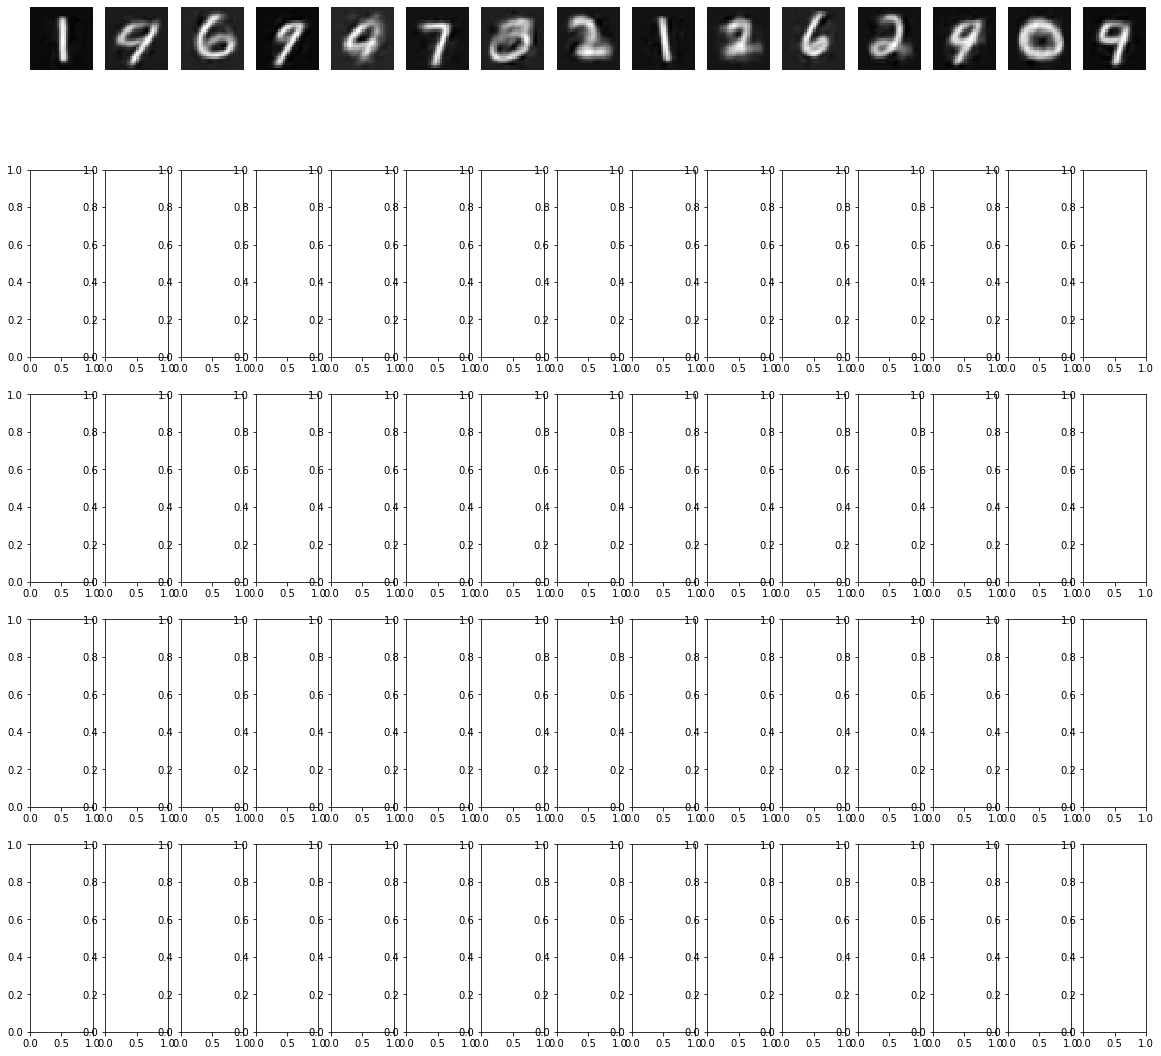

In [9]:
model_2 = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim= 32)
fig2, ax2 = plt.subplots(nrows=5, ncols=15, figsize=(20, 20))
i = 0
stop_epoch = 0
elbo_2 = []

for epoch in range(epochs):
    feed = {model_2.x: mnist2.test.images}
    test_elbo, test_z, test_samples, test_decoder_mu =  model_2.sess.run(
        [model_2.elbo, model_2.z, model_2.samples, model_2.decoder_mu], feed)
    elbo_2.append(-test_elbo)
    print('Epoch', epoch, 'elbo', -test_elbo)
    
    
    #set stop training criteria
    if epoch == 0:
        min_elbo = -test_elbo
    elif -test_elbo < min_elbo:
        min_elbo = -test_elbo
        stop_epoch = 0
    elif -test_elbo > min_elbo:
        stop_epoch+=1
    
    if stop_epoch > 10:
        print('stop at epoch', epoch)
        test_samples = test_samples.reshape([-1, 28, 28])
        model_2.plot_samples(ax2[i, :], test_samples)
        break
    
        
    #training step 
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model_2.run(batch)
        
print('train stop!')

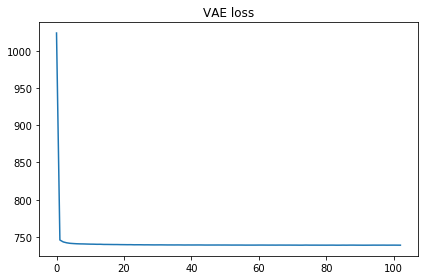

In [10]:
#32-dim latent space loss curve
plt.plot(elbo_2)
plt.title('VAE loss')
plt.tight_layout()